# Plot Figures 5-7


These figures show clustering metrics and PCA

For Sawi et al., 2021

## Todo::


* Why is cluster assignment changing in k-means even when I set random state to 0? Try 42??

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [7]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,catMergeFromH5,lagWF,calcCorr_template
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat, calcCorr_template, calcCCMatrix

from functions2 import getSpectra,getFP,getMaxIndexFP,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF, lagWF
import figureFunctions2

## Define helper functions (move later)

## Set paths

In [8]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathFigSupp = '../reports/supp_figures/'
pathAuxData = '../data/processed/Garcia/'

## Load auxiliary catalog

In [9]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')



## Define some important times in study period

In [10]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [11]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [12]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [13]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [14]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [15]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [16]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [17]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 5 - Reduce dimensionality, visualize PC plots by time, hour, cluster

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [18]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762941
3 0.277379352935
4 0.312981180759
5 0.343504124703
6 0.372574718716
7 0.39888893009
8 0.420886738848
9 0.43935279431
10 0.456412891221
11 0.472867011823
12 0.488673355757
13 0.503514622432
14 0.517479741469
15 0.530758064783
16 0.543709083603
17 0.556293871086
18 0.568416828751
19 0.580147086815
20 0.591286226545
21 0.602311294634
22 0.612600142707
23 0.621884252596
24 0.631230616094
25 0.640014166407
26 0.648626377656
27 0.656731243772
28 0.664997630762
29 0.67273803188
30 0.680514215263
31 0.687752241298
32 0.694913943709
33 0.702014048622
34 0.708950575797
35 0.715220975704
36 0.722117289949
37 0.72879293104
38 0.73458685245
39 0.740794839167
40 0.746961987411
41 0.752590133758
42 0.758336315252
43 0.763953501937
44 0.769315618433
45 0.774838364659
46 0.77989722969
47 0.78493325412
48 0.78973734389
49 0.794175237479
50 0.799456366552
51 0.803913615437
52 0.808185013273
53 0.812392556119
54 0.81675006124
55 0.820786645774
56 0.824843954977
57 0.82882

In [19]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.01% of variance explained by the first 66 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [20]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## PCA plot colored by datetime

In [21]:
hour_list = [h.hour for h in cat00.datetime]
hour_listN = [h.hour for h in cat00N.datetime]

cat00['hod'] = hour_list
cat00N['hod'] = hour_listN

In [22]:

series_datetime = cat00.datetime
series_datetimeN = cat00N.datetime


series_hour = cat00.hod
series_hourN = cat00N.hod


# Figure 6 - clustering results [using mean silh score, not median -- outliers should influence clustering]

## Clustering using Kmeans, validating using silhouette score

In [23]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


In [24]:
for k in range(1,Kopt+1):
    print(len(cat00[cat00.Cluster==k]))

    
print('\n')
for k in range(1,KoptN+1):
    print(len(cat00N[cat00N.Cluster==k]))

164
445
802


352
601
353
215


## Plot PCA with {topF} most representative events

In [25]:
topF = 20

catRep = getTopFCat(cat00,topF=topF)

catRepN = getTopFCat(cat00N,topF=topF)

# Plot 5 -- PCA with datetime, hour of day and cluster assignment

3 4


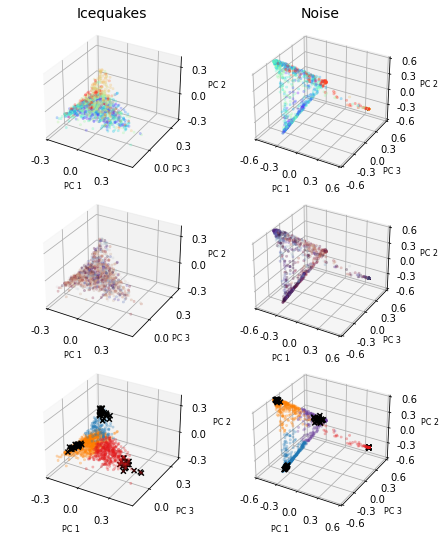

In [26]:
## Plot PCA by datetime, show rep events
tfont=14
plt.rcParams.update({'font.size': 10})


print(Kopt,KoptN)

fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')


size_dot = 4
alpha_dot = .3
size_rep = 25

label_fontsize = fontsize = 8

ax = fig.add_subplot(321, projection='3d')

figureFunctions2.plotPCA_Stat(cat00, catRep, 
                              series_datetime, 
                              stat_name='Date, 2007', 
                              Kopt=Kopt,
                              cmap=cmap, 
                              cbar=False, 
                              size=size_dot,
                              size2=0, 
                              alpha=alpha_dot,
                              labelpad=2, 
                              fontsize=fontsize,
                              ax=ax, 
                              fig=fig)


ax.set_title('Icequakes',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)


ax = fig.add_subplot(322, projection='3d')
figureFunctions2.plotPCA_Stat(cat00N, 
                              catRepN, 
                              series_datetimeN, 
                              stat_name='Date, 2007', 
                              Kopt=KoptN,
                              cmap=cmap, 
                              cbar=False, 
                              size=size_dot,
                              size2=0, 
                              alpha=alpha_dot,
                              labelpad=4, 
                              fontsize=fontsize,
                              ax=ax, 
                              fig=fig)

ax.set_title('Noise',fontsize=tfont)


cmap=cm.get_cmap('twilight_shifted')
ax = fig.add_subplot(323, projection='3d')
figureFunctions2.plotPCA_Stat(cat00, catRep, series_hour, stat_name='Hour (UTC)', Kopt=Kopt,cmap=cmap, cbar=False, size=size_dot,size2=0, alpha=alpha_dot,labelpad=2, fontsize=fontsize,ax=ax, fig=fig)
ax.set_title('',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)


ax = fig.add_subplot(324, projection='3d')
figureFunctions2.plotPCA_Stat(cat00N, catRepN, series_hourN, stat_name='Hour (UTC)', Kopt=KoptN,cmap=cmap, cbar=False, size=size_dot,size2=0, alpha=alpha_dot,labelpad=4, fontsize=fontsize,ax=ax, fig=fig)
ax.set_title('',fontsize=tfont)
# ax.set_title('Noise; Hour (UTC)',fontsize=tfont)
plt.subplots_adjust(wspace=0,hspace=0.2)



ax = fig.add_subplot(325, projection='3d')
figureFunctions2.plotPCA(cat00,catRep,Kopt, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)




ax = fig.add_subplot(326, projection='3d')
figureFunctions2.plotPCA(cat00N,catRepN,KoptN, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)



plt.subplots_adjust(wspace=0,hspace=0.1)




plt.savefig(pathFig + 'Figure_5.png')

### plot figure 5 colorbar

../src/visualization/figureFunctions2.py:1358: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))


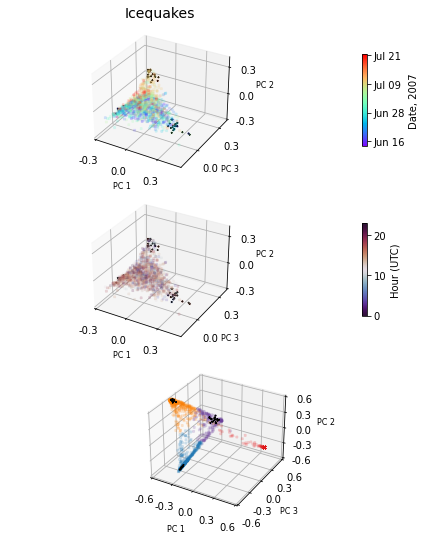

In [27]:
## Plot PCA by datetime, show rep events
tfont=14

plt.rcParams.update({'font.size': 10})



fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')


size_dot = 5
alpha_dot = .2
size_rep = 1

ax = fig.add_subplot(311, projection='3d')
figureFunctions2.plotPCA_Stat(cat00, catRep, series_datetime, stat_name='Date, 2007', Kopt=Kopt,cmap=cmap, cbar=True, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad=2, fontsize=8,ax=ax, fig=fig)
ax.set_title('Icequakes',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)


cmap=cm.get_cmap('twilight_shifted')
ax = fig.add_subplot(312, projection='3d')
figureFunctions2.plotPCA_Stat(cat00, catRep, series_hour, stat_name='Hour (UTC)', Kopt=Kopt,cmap=cmap, cbar=True, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad=2, fontsize=8,ax=ax, fig=fig)
ax.set_title('',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)

ax = fig.add_subplot(313, projection='3d')
figureFunctions2.plotPCA(cat00N,catRepN,KoptN, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=8,ax=ax, fig=fig, **plt_kwargs)



plt.subplots_adjust(wspace=0,hspace=0.1)

# # # prepare normalizer
# # ## Prepare bins for the normalizer
# # norm_bins = np.sort([*col_dict.keys()]) + 0.5
# # norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
# # print(norm_bins)
# # ## Make normalizer and formatter
# # norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
# # fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

plt.savefig(pathFig + 'Figure_5_colorbar.pdf')

### plot figure 5 silhScore

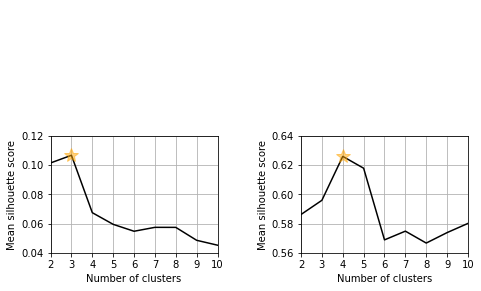

In [28]:
xlabelsize=10

fig,axes = plt.subplots(figsize = (width2,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')

### Plot silh Scores
ax = fig.add_subplot(223)
figureFunctions2.plotSilhScore(Kopt, avgSils, range_n_clusters_all,starSize=15,ax=ax)
ax.set_xlim(2,10)
ax.set_ylim(.04,.12)
ax.xaxis.label.set_size(xlabelsize)

ax = fig.add_subplot(224)
figureFunctions2.plotSilhScore(KoptN, avgSilsN, range_n_clusters_all,starSize=15,ax=ax)
plt.subplots_adjust(wspace=0.4,hspace=0.1)
ax.set_xlim(2,10)
ax.set_ylim(.56,.64)
ax.xaxis.label.set_size(xlabelsize)


plt.subplots_adjust(wspace=0.5,hspace=0.1)


plt.savefig(pathFig + 'Figure_5_silhScore.png')

## Get max state transition from FP (make list of selected states)



### Top FP

In [29]:
catRep1 = getTopFCat(cat00,1,0)
catRep1N = getTopFCat(cat00N,1,0)

### get select states from top fingerprint in each cluster

In [30]:
# ## get highest state transition in top fingerprint

    
sel_state = []
sel_stateN = []

for i, evID in enumerate(catRep1.event_ID):

    fp = getFP(evID,path_proj,outfile_name)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_state.append(argMaxFP)

for i, evID in enumerate(catRep1N.event_ID):

    fp = getFP(evID,path_projN,outfile_nameN)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_stateN.append(argMaxFP)
    

    
###
print('\n These are the selected state transitions :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state)
print('NS: ', sel_stateN)


 These are the selected state transitions :

IQ:  [(12, 12), (14, 14), (8, 8)]
NS:  [(3, 3), (6, 6), (5, 5), (4, 4)]


#### convert sel_state variable from tuple to single -- this works because key_states are on the diagonal of fingerprint of rep event


In [31]:
#### convert sel_state variable from tuple to single -- this works because key_states are on the diagonal of fingerprint of rep event

sel_state_single = [tup[0] for tup in sel_state if tup[0]==tup[1]]
sel_state_singleN = [tup[0] for tup in sel_stateN if tup[0]==tup[1]]
print('\n These are the key states :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state_single)
print('NS: ', sel_state_singleN)



 These are the key states :

IQ:  [12, 14, 8]
NS:  [3, 6, 5, 4]


## Plot Figure 6 FPs with circles around sel states

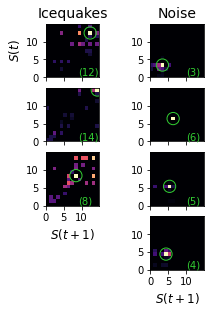

In [32]:
plt.figure(figsize=(width1,height1))

nRows = nR = 4
nCols = nC = 2

# fig, axes = plt.subplots(nRows,nCols)

gs = gridspec.GridSpec(nRows,nCols)

gs.update(wspace=0, hspace=0.2)

    
tfont = 14
symbolSize = 150    
shift = .4 #shift marker for selected states 

for i, evID in enumerate(catRep1.event_ID):


    ax=plt.subplot(gs[i,0])
    ax.set_aspect('equal')
    if i==0:
        ax.set_title('Icequakes',fontsize=tfont)
        ax.set_ylabel('$S(t)$',fontsize=tfont-2)
        
    else:
        ax.set_ylabel('')
        

        
    #normalize fps by local max
    fp = getFP(evID,path_proj,outfile_name) 
    fp = fp / np.max(fp)
        

    ## plot FP
    plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')

    
    

    ## plot symbol on key states

    plt.scatter(sel_state[i][1]+shift,
                sel_state[i][0]+shift,
                symbolSize,
                edgecolors='limegreen',
                color='None',
                marker='o',
                linewidths=1)    

    ax.text(9,.5,f'({sel_state[i][0]})',color='limegreen',size=10)
    
    #ticks
    plt.yticks(ticks = [0,5,10],labels=['0','5','10'])
    plt.xticks(ticks = [0,5,10],labels=['0','5','10'])

    #labels
    if i == Kopt-1:
        ax.set_xlabel('$S(t+1)$',fontsize=tfont-2)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    i == Kopt-1
        
    

    
    
for i, evID in enumerate(catRep1N.event_ID):


    ax=plt.subplot(gs[i,1])
    ax.set_aspect('equal')
    if i==0:        
        ax.set_title('Noise',fontsize=tfont)

#     ax.axis('off')
    #normalize fps by local max
    fp = getFP(evID,path_projN,outfile_nameN) 
    fp = fp / np.max(fp)
        

    ## plot FP
    plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
    #colorbar
    
#     plt.colorbar(pad=.1, shrink=.6)

    ## plot symbol on key states

    plt.scatter(sel_stateN[i][1]+shift,
                sel_stateN[i][0]+shift,
                symbolSize,
                edgecolors='limegreen',
                color='None',
                marker='o',
                linewidths=1)    

    
    ax.text(10,.5,f'({sel_stateN[i][0]})',color='limegreen',size=10)
    ##ticks
    plt.yticks(ticks = [0,5,10],labels=['0','5','10'])
    plt.xticks(ticks = [0,5,10],labels=['0','5','10'])

    #labels
    #labels
    if i == KoptN-1:
        ax.set_xlabel('$S(t+1)$',fontsize=tfont-2)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
        

    
    
plt.savefig(pathFig + f'Figure_6.pdf',bbox_inches='tight')

In [33]:
## plot colorbar

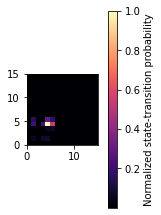

In [34]:
plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width1,height1))

gs = gridspec.GridSpec(nRows,nCols)

ax=plt.subplot(gs[:,1])

plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
plt.colorbar(pad=.1, shrink=.8,label='Normalized state-transition probability')



ax.set_aspect('equal')
plt.savefig(pathFig + f'Figure_7_colorbar.pdf',bbox_inches='tight')

# Figure 7 rep wf spectra and reconstructed spectra

## Get vector of lag times for template waveform


### Template wf is most represetnative wf in this case, so index 0 in the CC lag time catalog

In [35]:
shift_cc = lenData
shift_ccN = lenDataN

In [37]:
catRep5 = getTopFCat(cat00,5)
catRep5N = getTopFCat(cat00N,5)

cc_mat, lag_mat = calcCCMatrix(catRep5,shift_cc, dataH5_path , station, channel, fmin, fmax, fs)
cc_matN, lag_matN = calcCCMatrix(catRep5N,shift_ccN, dataH5_pathN , station, channel, fminN, fmaxN, fsN)

In [ ]:
# plt.rcParams.update({'font.size': 8})


# ##offset waveforms for visual clarity
# offset = True

# count =0
# tpad=13
# tfont=10
# bW = 2#spine bar width
# bA = 1
# fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


# gs = gridspec.GridSpec(9, 5)

# # gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
# gs.update(wspace=.01, hspace=.1)

# date_str_font = 2

# for k in range(1,Kopt+1):
    
#     lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster
# #     print(lag0)
#     ax=plt.subplot(gs[k-1,0:2])
    
#     catRepK = catRep[catRep.Cluster==k]
    
#     for i, evID in enumerate(catRepK.event_ID):
    
    
# #         k = int(catRep.Cluster.iloc[i])
    
#         date_str = str(catRepK.datetime.iloc[i])[5:]

#         # load wf from H5
#         wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
#         #Norm by max and zero mean
#         wf_norm = wf / np.max(wf)        
#         wf_zeromean = wf_norm - np.mean(wf_norm)
        
        
#         #Offset for visual clarity
#         if offset==False:
#             wf_offset = wf_zeromean
#         else:
#             wf_offset = (wf_zeromean - 6) + 1.6 * i
            
#         waveform_shift = lagWF(wf_offset, lag0, index_wf=i+(k-1)*5)

            
#         text_y = wf_offset[0]+.2
        
#         ##plot !!
        
#         ax.plot(waveform_shift,lw=.5,c=colors[k-1])
# #         print(waveform_shift)
        
#         ax.set_yticklabels('')    
#         ax.set_yticks([])        
        
        
#         ax.text(lenData-lenData//4,text_y,date_str,c='k',fontsize=date_str_font)
           
    
#     # hide the spines between ax and ax2
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_visible(False)


        
#     if k ==Kopt:    
#         ax.set_xlabel('',labelpad=4)   
#         ax.set_xticks([0,1000,2000])
#         ax.set_xticklabels(['0','1','2'])        
        
# #         ax.set_xlabel('t (s)',labelpad=4)   
# #         ax.set_xticks([0,1000,2000])
# #         ax.set_xticklabels(['0','1','2'])        
                
        
#     else:
#         ax.spines['bottom'].set_visible(False)

#         ax.set_xlabel('',labelpad=4)   
#         ax.set_xticks([])
#         ax.set_xticklabels('')  

    
#     ##plot arrow00
#     ax=plt.subplot(gs[k-1,2])
#     if k==1:
#         ax.set_title('Icequakes',fontsize=13)
#         ax.text(0.2,.3,r'$\rightarrow$',fontsize=20)  
#     else:
#         ax.text(0.25,.3,r'$\rightarrow$',fontsize=20)          
#     ax.axis('off')
      
        
        
# #     plot spectra:
#     ax = plt.subplot(gs[k-1,3:5])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     for i, evID in enumerate(catRepK.event_ID):
#         matSum, specMat = getSpectra(evID,station,path_proj,normed=True)
#         ax.plot(fSTFT,matSum,lw=.5,c=colors[k-1])
#         plt.grid('on')
        
#     if k==1:
#         ax.set_ylabel('$dB$',labelpad=0)   
#         ax.set_yticks([50,150])
#         ax.set_yticklabels(['50','150'])  
#     else:
#         ax.set_ylabel('')   
# #         ax.set_yticks([])
# #         ax.set_yticklabels('') 
# #     ax.set_yscale('log')

    
#     ## plot reconstructed spectra
#     ax2=ax.twinx()
#     figureFunctions2.plotReconstructedStates(RMM,[sel_state_single[k-1]],fSTFT,ax=ax2,colorBy='all',lw=1,freq_list=None,scale=1,normed='max',legend=None,**plt_kwargs)
#     ax2.set_xlabel('')
#     if k != 2:
#         ax2.set_ylabel('')
#         ax2.set_yticklabels('')        
#         ax2.set_yticks([])  
# #     ax2.set_yscale('log')
        
        
    
#     if k ==Kopt:    
#         ax.set_xlabel('',labelpad=4)   

#     else:

#         ax.set_xticklabels('')  

    
# for k in range(1,KoptN+1):
    
    
#     ax=plt.subplot(gs[k-1+Kopt+1,0:2])
#     lag0 = lag_matN[(k-1)*5,:] ## get template for each cluster

#     catRepK = catRepN[catRepN.Cluster==k]
# #     print(k,len(catRepK))
#     for i, evID in enumerate(catRepK.event_ID):
    
# #         k = int(catRep.Cluster.iloc[i])
    
    
#         date_str = str(catRepK.datetime.iloc[i])[5:]

#         # load wf from H5
#         wf = getWF(str(evID),dataH5_pathN,station,channel,fminN,fmaxN,fsN)

#         #Norm by max and zero mean
#         wf_norm = wf / np.max(wf)        
#         wf_zeromean = wf_norm - np.mean(wf_norm)
        
#         #Offset for visual clarity
#         if offset==False:
#             wf_offset = wf_zeromean
#         else:
#             wf_offset = (wf_zeromean - 6) + 1.6 * i
            
#         waveform_shift = lagWF(wf_offset, lag0, index_wf=i+(k-1)*5)

        
        
#         ##plot !!
        
#         ax.plot(waveform_shift,lw=.5,c=colors[k-1])
        
        
#         ax.set_yticklabels('')    
#         ax.set_yticks([])        
        
#         text_y = wf_offset[0]-.1

#         ax.text(lenDataN-lenDataN//4,text_y,date_str,c='k',fontsize=date_str_font)
           
    
#     # hide the spines between ax and ax2
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_visible(False)


        
#     if k ==KoptN:    
#         ax.set_xlabel('$t$ (s)',fontsize=tfont,labelpad=4)   
#         ax.set_xticks([0,30000,60000])
#         ax.set_xticklabels(['0','30','60'])        
        
#     else:
#         ax.spines['bottom'].set_visible(False)

#         ax.set_xlabel('',labelpad=4)   
#         ax.set_xticks([])
#         ax.set_xticklabels('')  

    
#     ##plot arrow00
#     ax=plt.subplot(gs[k-1+Kopt+1,2])
#     if k==1:
#         ax.set_title('Noise',fontsize=13)    
#     ax.text(0.25,.3,r'$\rightarrow$',fontsize=20)  
#     ax.axis('off')
      
        
        
# #     plot sgram:
#     ax = plt.subplot(gs[k-1+Kopt+1,3:5])
# #     ax.set_yscale('log')

#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     for i, evID in enumerate(catRepK.event_ID):
#         matSum, specMat = getSpectra(evID,station,path_projN,normed=True)
#         ax.plot(fSTFTN,matSum,lw=.5,c=colors[k-1])
#         plt.grid('on')
        
#     ## plot reconstructed spectra
#     ax2=ax.twinx()
#     ax2.set_xlabel('')
  
#     figureFunctions2.plotReconstructedStates(RMMN,[sel_state_singleN[k-1]],fSTFTN,ax=ax2,colorBy='all',lw=1,freq_list=None,scale=1,normed='max',legend=None,**plt_kwargs)


#     if k != 2:
#         ax2.set_ylabel('')
#         ax2.set_yticklabels('')        
#         ax2.set_yticks([])  
        


        
#     if k ==KoptN:    
#         ax.set_xlabel('$f$ (Hz)',fontsize=tfont,labelpad=4)   

#     else:

#         ax.set_xticklabels('')  

        

        

        

    
# plt.savefig(pathFig + f'Figure_7.pdf',bbox_inches='tight')

## Finding CC and Lag matrices for top {10,20,30,40,50,100} events


In [141]:

topF = 5
catRep = getTopFCat(cat00,topF=topF) 
catRepN = getTopFCat(cat00N,topF=topF)

print(f'calculating IQ CC topF = {topF}...')
cc_mat5,lag_mat5 = calcCCMatrix(catRep,lenData,dataH5_path,station,channel,fmin,fmax,fs)

print(f'calculating NS CC topF = {topF}...')

cc_mat5N,lag_mat5N = calcCCMatrix(catRepN,lenDataN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)






# np.save(f'../data/interim/ccMat_top{topF}.npy',cc_mat100)
# np.save(f'../data/interim/ccLagMat_top{topF}.npy',lag_mat100)



calculating CC topF = 5...
saving CC topF = 5...


# Figure 7

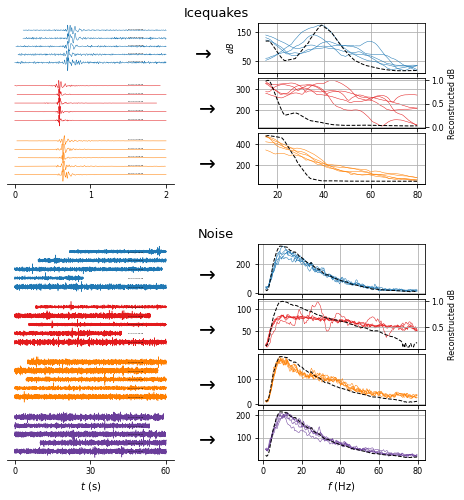

In [126]:
plt.rcParams.update({'font.size': 8})


##offset waveforms for visual clarity
offset = True

count =0
tpad=13
tfont=10
bW = 2#spine bar width
bA = 1
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


gs = gridspec.GridSpec(9, 5)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.01, hspace=.1)

date_str_font = 2

for k in range(1,Kopt+1):
    
    lag0 = lag_mat5[(k-1)*5,:] ## get template for each cluster
#     print(lag0)
    ax=plt.subplot(gs[k-1,0:2])
    
    catRepK = catRep[catRep.Cluster==k]
    
    for i, evID in enumerate(catRepK.event_ID):
    
    
#         k = int(catRep.Cluster.iloc[i])
    
        date_str = str(catRepK.datetime.iloc[i])[5:]

        # load wf from H5
        wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
        #Norm by max and zero mean
        wf_norm = wf / np.max(wf)        
        wf_zeromean = wf_norm - np.mean(wf_norm)
        
        
        #Offset for visual clarity
        if offset==False:
            wf_offset = wf_zeromean
        else:
            wf_offset = (wf_zeromean - 6) + 1.6 * i
            
        waveform_shift = lagWF(wf_offset, lag0, index_wf=i+(k-1)*5)

            
        text_y = wf_offset[0]+.2
        
        ##plot !!
        
        ax.plot(waveform_shift,lw=.5,c=colors[k-1])
#         print(waveform_shift)
        
        ax.set_yticklabels('')    
        ax.set_yticks([])        
        
        
        ax.text(lenData-lenData//4,text_y,date_str,c='k',fontsize=date_str_font)
           
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)


        
    if k ==Kopt:    
        ax.set_xlabel('',labelpad=4)   
        ax.set_xticks([0,1000,2000])
        ax.set_xticklabels(['0','1','2'])        
        
#         ax.set_xlabel('t (s)',labelpad=4)   
#         ax.set_xticks([0,1000,2000])
#         ax.set_xticklabels(['0','1','2'])        
                
        
    else:
        ax.spines['bottom'].set_visible(False)

        ax.set_xlabel('',labelpad=4)   
        ax.set_xticks([])
        ax.set_xticklabels('')  

    
    ##plot arrow00
    ax=plt.subplot(gs[k-1,2])
    if k==1:
        ax.set_title('Icequakes',fontsize=13)
        ax.text(0.2,.3,r'$\rightarrow$',fontsize=20)  
    else:
        ax.text(0.25,.3,r'$\rightarrow$',fontsize=20)          
    ax.axis('off')
      
        
        
#     plot spectra:
    ax = plt.subplot(gs[k-1,3:5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for i, evID in enumerate(catRepK.event_ID):
        matSum, specMat = getSpectra(evID,station,path_proj,normed=True)
        ax.plot(fSTFT,matSum,lw=.5,c=colors[k-1])
        plt.grid('on')
        
    if k==1:
        ax.set_ylabel('$dB$',labelpad=0)   
        ax.set_yticks([50,150])
        ax.set_yticklabels(['50','150'])  
    else:
        ax.set_ylabel('')   
#         ax.set_yticks([])
#         ax.set_yticklabels('') 
#     ax.set_yscale('log')

    
    ## plot reconstructed spectra
    ax2=ax.twinx()
    figureFunctions2.plotReconstructedStates(RMM,[sel_state_single[k-1]],fSTFT,ax=ax2,colorBy='all',lw=1,freq_list=None,scale=1,normed='max',legend=None,**plt_kwargs)
    ax2.set_xlabel('')
    if k != 2:
        ax2.set_ylabel('')
        ax2.set_yticklabels('')        
        ax2.set_yticks([])  
#     ax2.set_yscale('log')
        
        
    
    if k ==Kopt:    
        ax.set_xlabel('',labelpad=4)   

    else:

        ax.set_xticklabels('')  

    
for k in range(1,KoptN+1):
    
    
    ax=plt.subplot(gs[k-1+Kopt+1,0:2])
    lag0 = lag_mat5N[(k-1)*5,:] ## get template for each cluster

    catRepK = catRepN[catRepN.Cluster==k]
#     print(k,len(catRepK))
    for i, evID in enumerate(catRepK.event_ID):
    
#         k = int(catRep.Cluster.iloc[i])
    
    
        date_str = str(catRepK.datetime.iloc[i])[5:]

        # load wf from H5
        wf = getWF(str(evID),dataH5_pathN,station,channel,fminN,fmaxN,fsN)

        #Norm by max and zero mean
        wf_norm = wf / np.max(wf)        
        wf_zeromean = wf_norm - np.mean(wf_norm)
        
        #Offset for visual clarity
        if offset==False:
            wf_offset = wf_zeromean
        else:
            wf_offset = (wf_zeromean - 6) + 1.6 * i
            
        waveform_shift = lagWF(wf_offset, lag0, index_wf=i+(k-1)*5)

        
        
        ##plot !!
        
        ax.plot(waveform_shift,lw=.5,c=colors[k-1])
        
        
        ax.set_yticklabels('')    
        ax.set_yticks([])        
        
        text_y = wf_offset[0]-.1

        ax.text(lenDataN-lenDataN//4,text_y,date_str,c='k',fontsize=date_str_font)
           
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)


        
    if k ==KoptN:    
        ax.set_xlabel('$t$ (s)',fontsize=tfont,labelpad=4)   
        ax.set_xticks([0,30000,60000])
        ax.set_xticklabels(['0','30','60'])        
        
    else:
        ax.spines['bottom'].set_visible(False)

        ax.set_xlabel('',labelpad=4)   
        ax.set_xticks([])
        ax.set_xticklabels('')  

    
    ##plot arrow00
    ax=plt.subplot(gs[k-1+Kopt+1,2])
    if k==1:
        ax.set_title('Noise',fontsize=13)    
    ax.text(0.25,.3,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
      
        
        
#     plot sgram:
    ax = plt.subplot(gs[k-1+Kopt+1,3:5])
#     ax.set_yscale('log')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for i, evID in enumerate(catRepK.event_ID):
        matSum, specMat = getSpectra(evID,station,path_projN,normed=True)
        ax.plot(fSTFTN,matSum,lw=.5,c=colors[k-1])
        plt.grid('on')
        
    ## plot reconstructed spectra
    ax2=ax.twinx()
    ax2.set_xlabel('')
  
    figureFunctions2.plotReconstructedStates(RMMN,[sel_state_singleN[k-1]],fSTFTN,ax=ax2,colorBy='all',lw=1,freq_list=None,scale=1,normed='max',legend=None,**plt_kwargs)


    if k != 2:
        ax2.set_ylabel('')
        ax2.set_yticklabels('')        
        ax2.set_yticks([])  
        


        
    if k ==KoptN:    
        ax.set_xlabel('$f$ (Hz)',fontsize=tfont,labelpad=4)   

    else:

        ax.set_xticklabels('')  

        

        

        

    
plt.savefig(pathFigSupp + f'Figure_7.pdf',bbox_inches='tight')

# Figure 7B - all reconstr states and spectra medians

### find scale for reconstructed states

In [175]:
sel_state_single = [sss[0] for sss in sel_state]
sel_state_singleN = [sss[0] for sss in sel_stateN]

sel_state_single,sel_state_singleN

([12, 14, 8], [3, 6, 5, 4])

In [176]:
k = 1
peak_rec_state, peak_spec, scale = CalcDiffPeak(path_proj,cat00,k,RMM,sel_state_single,station)
print(peak_rec_state, peak_spec, scale)

kN=3
peak_rec_stateN, peak_specN, scaleN = CalcDiffPeak(path_projN,cat00N,kN,RMMN,sel_state_singleN,station)
print(peak_rec_stateN, peak_specN, scaleN)


16578701 180 16578521
12211956 177 12211778


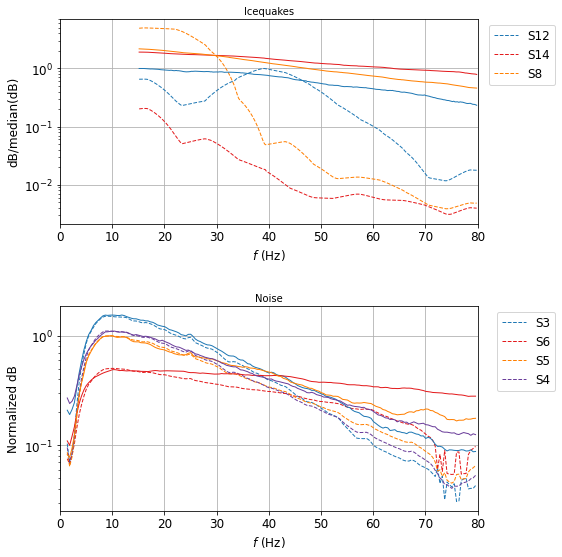

In [180]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,1)
gs.update(wspace=.4, hspace=.4)
leg = legN = ['','','','','','','','','','','']

title='Icequakes'
titleN='Noise'
# freq_list = np.arange(fmin,fmax,10)

tpad=4

### ### ### ### ### ### ### ### ### ### ### ### 
## EVENT
ax = plt.subplot(gs[0])
ax.set_xlim(0,80)
ax.set_xlabel('$f$ (Hz)')

ax.set_ylabel('Normalized dB')
# ax.set_ylim(0,.5e9)
# R2=0
# ax.text(40,6e7,f'$MAE={MAE}$',fontsize=10)

ax.set_title(title,fontsize=tfont,pad=tpad)  
figureFunctions2.plotReconstructedStates(RMM,sel_state_single,fSTFT,lw=1,freq_list=None,normed='median',scale=peak_rec_state,**plt_kwargs)

ax.legend(loc='upper right',bbox_to_anchor=(1.2,1))

figureFunctions2.plotMedianSpectra(path_proj,cat00,Kopt,fSTFT,station,leg,normed='median',ax=ax,scale=peak_spec,**plt_kwargs)
plt.yscale('log')
# plt.xscale('log')


### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[1])
ax.set_xlim(0,80)
# ax.set_ylim(0,2.25e7)
# ax.set_ylim(ymin=0)
ax.set_title(titleN,fontsize=tfont,pad=tpad)
  
figureFunctions2.plotReconstructedStates(RMMN,sel_state_singleN,fSTFTN,lw=1,freq_list=None,normed='median',scale=peak_rec_stateN,**plt_kwargs)



ax.legend(loc='upper right',bbox_to_anchor=(1.2,1))



figureFunctions2.plotMedianSpectra(path_projN,cat00N,KoptN,fSTFTN,station,legN,lw=1,normed='median',scale=peak_specN,ax=ax,**plt_kwargs)
ax.set_ylabel('Normalized dB')
ax.set_xlabel('$f$ (Hz)')


# state_minMAE = sel_stateN[kmaxN-1]

# ax.text(40,1.25e7,r'$R^2 _{S3}=$'+f'{r2_maxN:.3f}',fontsize=14,c=colors[kmaxN-1])



plt.yscale('log')
# plt.xscale('log')

plt.savefig(pathFig + f'Figure_7_Combined.pdf',bbox_inches='tight')

## Align icequake waveforms in time....

In [181]:
# np.load(cc100_mat)

topF = 100
catRep = getTopFCat(cat00,topF)
lag_matN = eval(f'lag_mat{topF}')

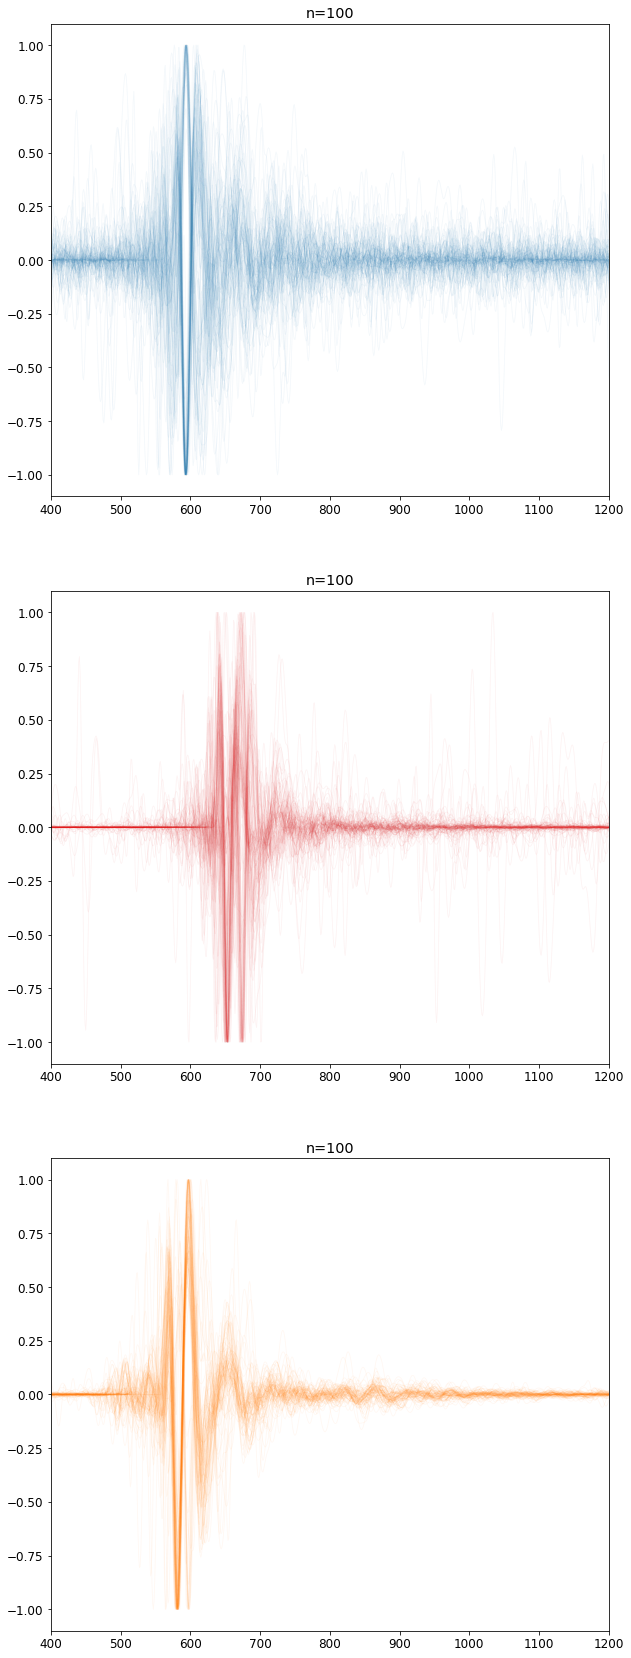

In [185]:
## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (10,40))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(4,2)

lw=.8
alpha=.05


# for k in range(1,Kopt+1):
    

    

for i, evID in enumerate(catRep.event_ID):    

    date_str = str(catRep.datetime.iloc[i])[5:]
    k = catRep.Cluster.iloc[i]

    
    lag0 = lag_matN[(k-1)*5,:] ## get template for each cluster
    
    ax=plt.subplot(gs[k-1,0:2]);
    
    # load wf from H5
    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 0
    wf_offset = (wf_zeromean) + i*offset#1.5
#     wf_offset = 0
    
#         wf_zeromean_pad = lagWF(catRepK,wf_zeromean,lag_0)
    waveform_shift = lagWF(wf_offset, lag0, index_wf=i)
    ##plot !!

    plt.plot(waveform_shift,lw=lw,alpha=alpha,c=colors[k-1])
#         plt.plot(wf_offset,lw=.5,c=colors[k-1])

    plt.title(f'n={topF}')

#         plt.plot(wf_zeromean_pad,lw=.5,c=colors[k-1])        
    
    xmin = 400
    xmax = 1200
    plt.xlim(xmin,xmax)
#     xmin = 0
#     xmax = len(waveform_shift)

plt.savefig(pathFigSupp+ f'Supp_aligned_IQWF_top{topF}_offset{offset}_{xmin}-{xmax}_alph{alpha}_lw{lw}_NormMax.png')